In [1]:

import kagglehub
nodoubttome_skin_cancer9_classesisic_path = kagglehub.dataset_download('nodoubttome/skin-cancer9-classesisic')
hasnainjaved_melanoma_skin_cancer_dataset_of_10000_images_path = kagglehub.dataset_download('hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images')

print('Data source import complete.')


Using Colab cache for faster access to the 'skin-cancer9-classesisic' dataset.


100%|██████████| 98.7M/98.7M [00:00<00:00, 132MB/s]

Extracting files...


Data source import complete.


In [3]:
!pip install tensorflow


# Step 1 : Importing Essetial Libraries

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Step 2 : Importing Data and Creating a Dataframe

In [9]:
import os
import pandas as pd

train_dir = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_dir = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

# Create lists to store image paths and labels
train_data = []
test_data = []

# Add images paths and labels to lists
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_data.append({'image_path': image_path, 'label': label})

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_data.append({'image_path': image_path, 'label': label})

# Create dataframes from the lists
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)


# Combine train_df and test_df into one dataframe
df = pd.concat([train_df, test_df], ignore_index=True)
del test_df,train_df
df

,image_path,label
0,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
1,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
2,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
3,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
4,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
...,...,...
2352,/kaggle/input/skin-cancer9-classesisic/Skin ca...,8
2353,/kaggle/input/skin-cancer9-classesisic/Skin ca...,8
2354,/kaggle/input/skin-cancer9-classesisic/Skin ca...,8
2355,/kaggle/input/skin-cancer9-classesisic/Skin ca...,8


In [10]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'pigmented benign keratosis',
 1: 'melanoma',
 2: 'vascular lesion',
 3: 'actinic keratosis',
 4: 'squamous cell carcinoma',
 5: 'basal cell carcinoma',
 6: 'seborrheic keratosis',
 7: 'dermatofibroma',
 8: 'nevus'}

# Step 3 : EDA

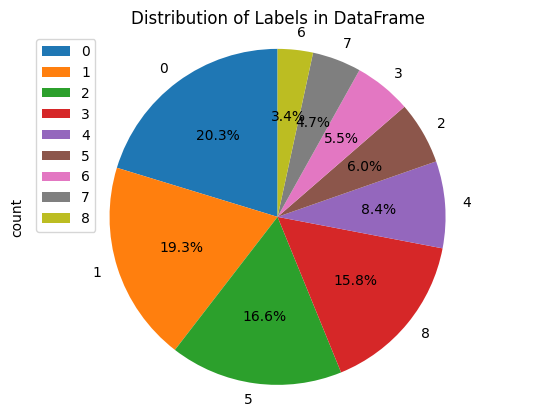

In [11]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [12]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               pigmented benign keratosis     478       
1               melanoma                       454       
2               vascular lesion                142       
3               actinic keratosis              130       
4               squamous cell carcinoma        197       
5               basal cell carcinoma           392       
6               seborrheic keratosis           80        
7               dermatofibroma                 111       
8               nevus                          373       
------------------------------------------------------------
Total                                         2357      


# Step 4 : Loading and resizing of images

In [13]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

/tmp/ipython-input-3886418994.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


In [14]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


In [15]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

2

In [16]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

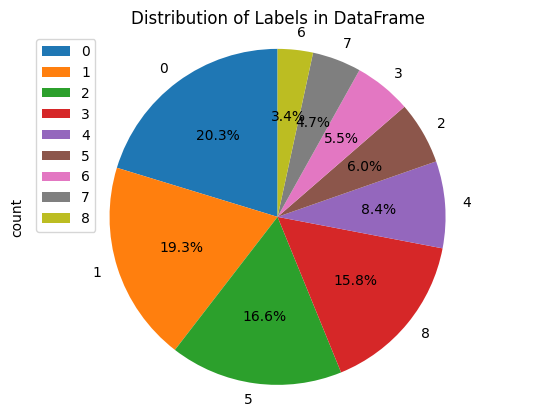

In [17]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [18]:
df.head()

,image_path,label,image
0,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0,"[[[152, 131, 151], [153, 131, 151], [150, 128,..."
1,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0,"[[[170, 137, 151], [172, 140, 156], [170, 138,..."
2,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0,"[[[247, 170, 159], [247, 169, 159], [244, 166,..."
3,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0,"[[[174, 143, 162], [173, 142, 162], [171, 138,..."
4,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0,"[[[144, 124, 134], [147, 127, 138], [151, 131,..."


> # Displaying the total number of images of each Class before Data Augmentation

In [19]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               pigmented benign keratosis     478       
1               melanoma                       454       
2               vascular lesion                142       
3               actinic keratosis              130       
4               squamous cell carcinoma        197       
5               basal cell carcinoma           392       
6               seborrheic keratosis           80        
7               dermatofibroma                 111       
8               nevus                          373       
------------------------------------------------------------
Total                                         2357      


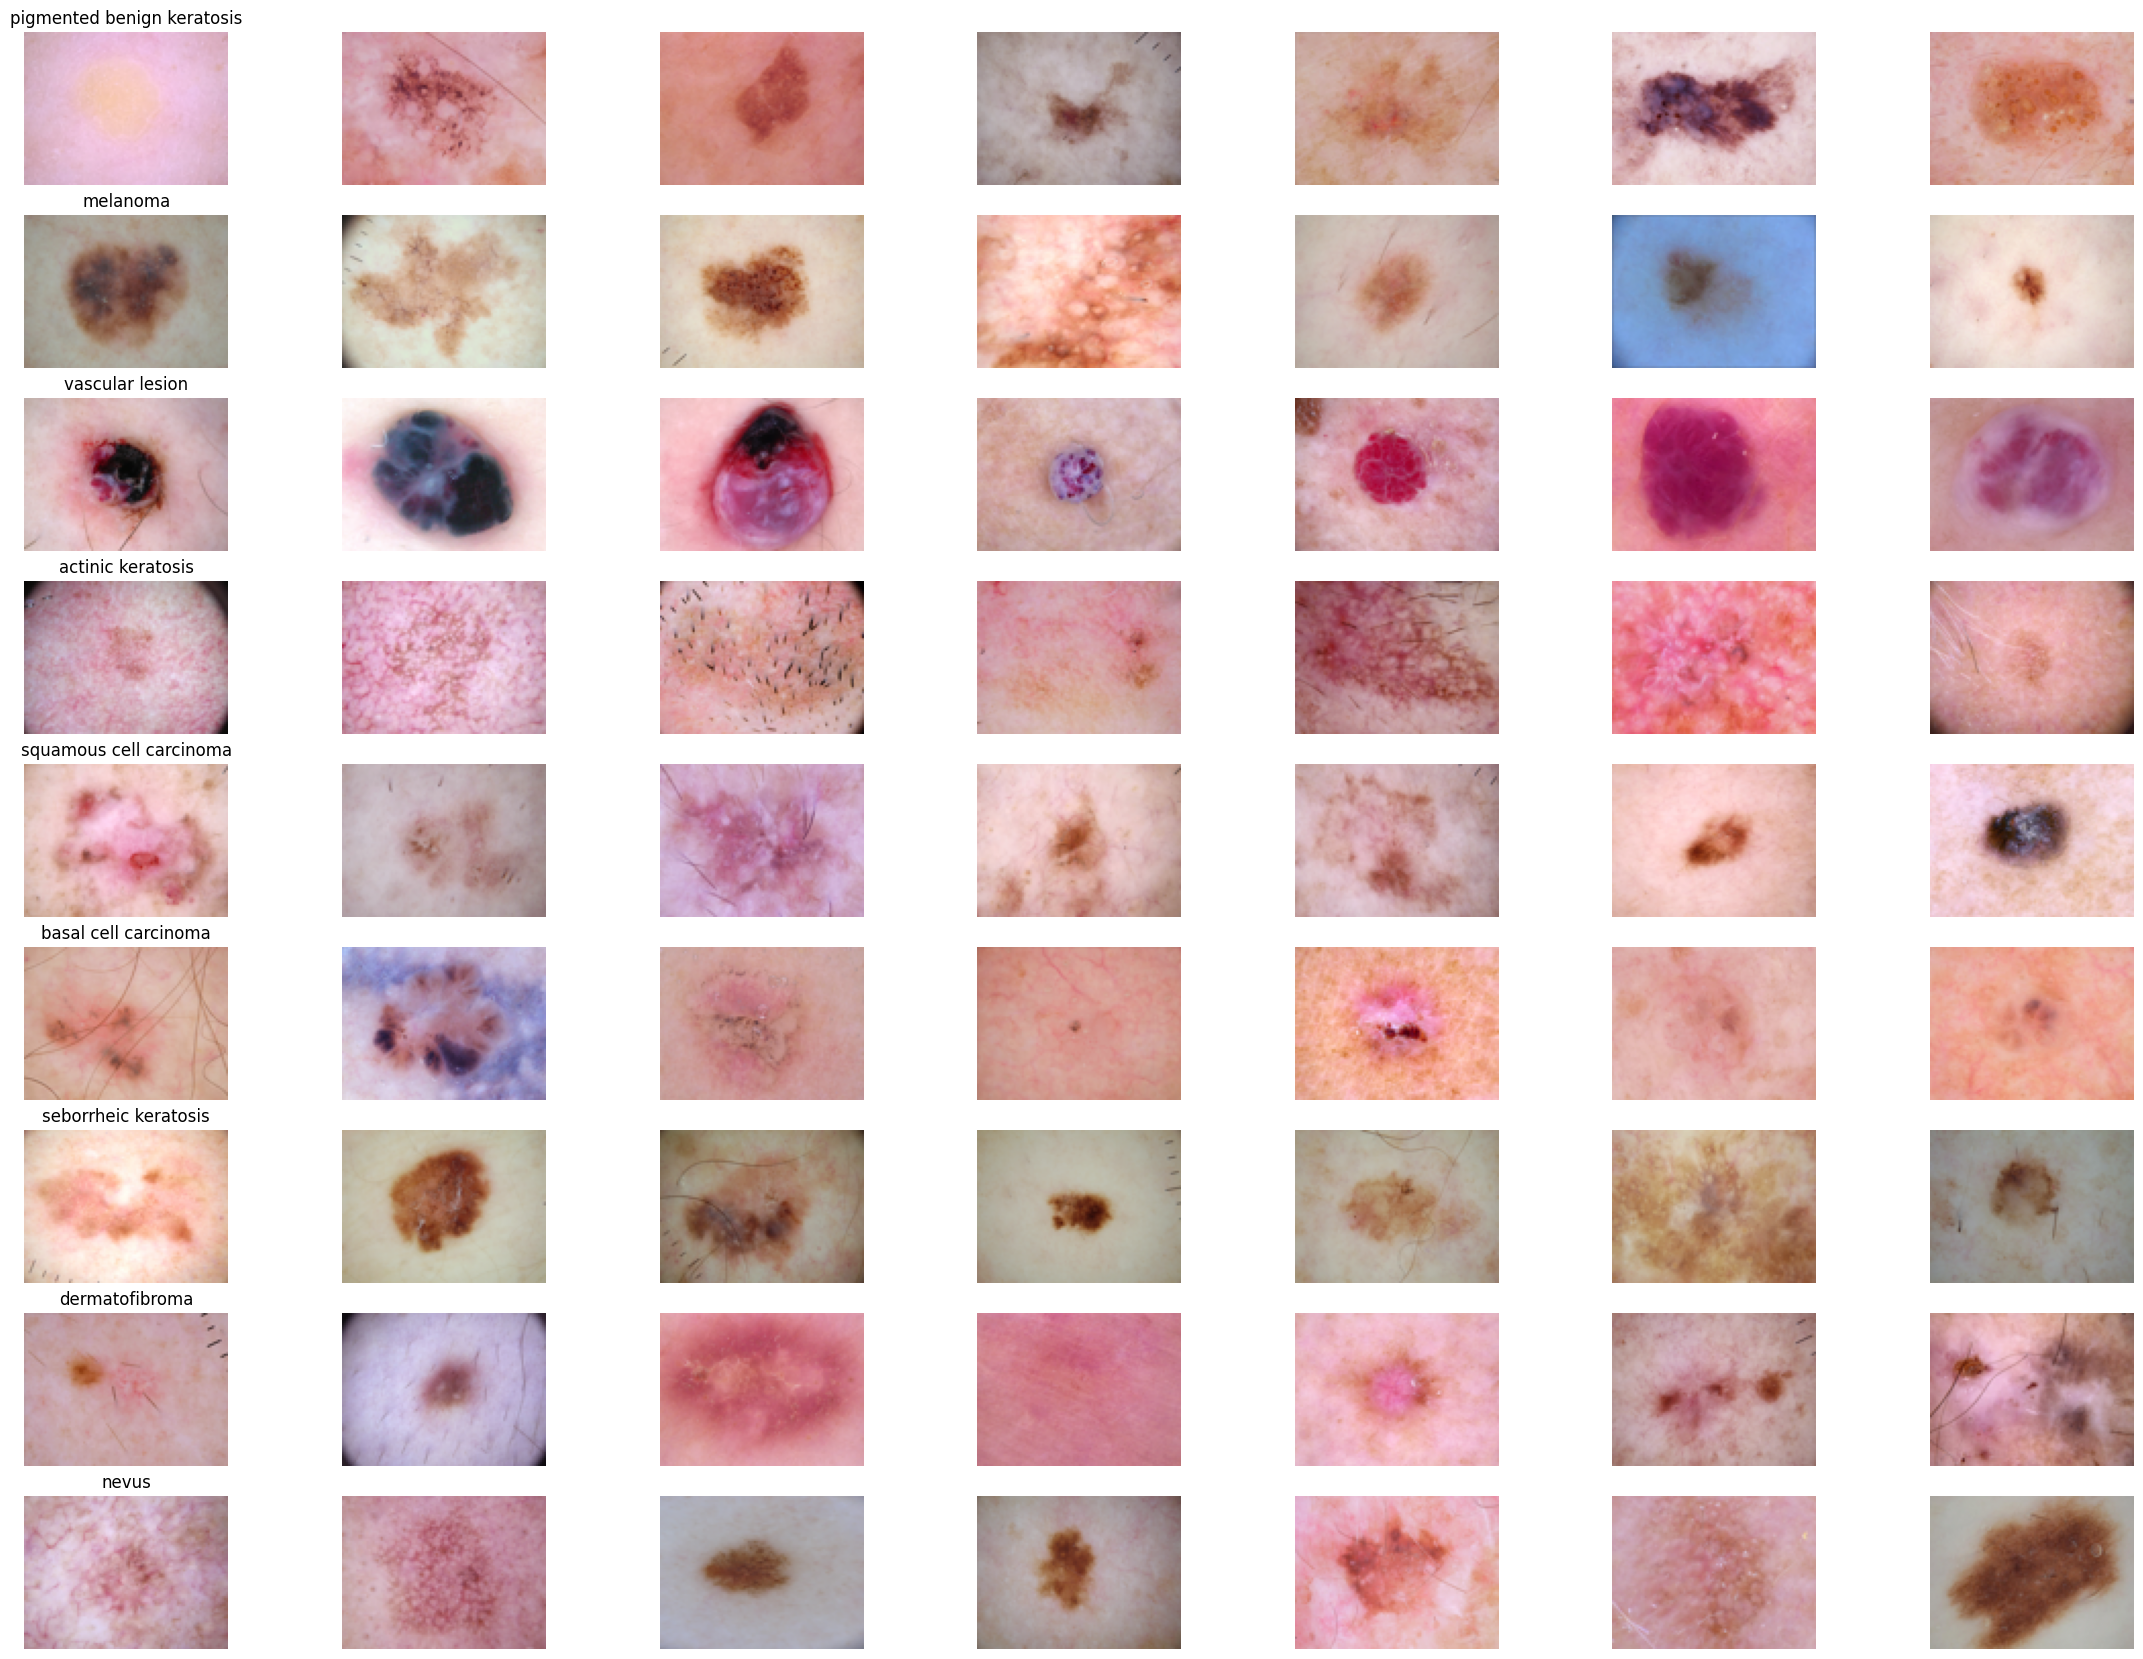

In [20]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [21]:
df['image'].map(lambda x: x.shape).value_counts()

,count
image,
"(75, 100, 3)",2357


# Step 5 : Data Augmentation

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [29]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Example: define your ImageDataGenerator with augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create an empty list to store augmented data
augmented_data = []

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    class_df = df.loc[df['label'] == class_label].copy()
    image_arrays = np.stack(class_df['image'].values)

    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)

    # Generate augmented images for the current class if needed
    if num_images_needed > 0:
        # Use datagen.flow to generate augmented images
        augmented_generator = datagen.flow(image_arrays, batch_size=1, shuffle=False)

        # Generate the required number of augmented images
        generated_images = []
        for _ in range(num_images_needed):
            batch = next(augmented_generator)   # FIXED: use next() instead of .next()
            generated_images.append(batch[0].astype('uint8'))

        # Create a temporary DataFrame for the generated images
        generated_df = pd.DataFrame({
            'image_path': [None] * num_images_needed,
            'label': [class_label] * num_images_needed,
            'image': generated_images
        })
        augmented_data.append(generated_df)

    # Add the original images for the current class to the list
    augmented_data.append(class_df)

# Concatenate all dataframes in the list
df = pd.concat(augmented_data, ignore_index=True)

# Shuffle the dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Augmentation complete! Final dataset shape:", df.shape)


Augmentation complete! Final dataset shape: (22500, 3)


> # Displaying the total number of images of each Class after Data Augmentation

In [30]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               pigmented benign keratosis     2500      
1               melanoma                       2500      
2               vascular lesion                2500      
3               actinic keratosis              2500      
4               squamous cell carcinoma        2500      
5               basal cell carcinoma           2500      
6               seborrheic keratosis           2500      
7               dermatofibroma                 2500      
8               nevus                          2500      
------------------------------------------------------------
Total                                         22500     


# Step 6 : Train and Test split

In [31]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [32]:
features.head()

,image
0,"[[[186, 92, 107], [186, 91, 104], [186, 89, 10..."
1,"[[[199, 160, 186], [199, 158, 184], [201, 159,..."
2,"[[[246, 189, 191], [246, 189, 191], [246, 189,..."
3,"[[[187, 156, 160], [189, 160, 160], [189, 157,..."
4,"[[[224, 194, 197], [222, 192, 193], [223, 192,..."


In [33]:
target.head()

,label
0,0
1,3
2,7
3,3
4,4


In [34]:
print(target.shape,features.shape)

(22500,) (22500, 1)


In [35]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

# Step 7 : Normalization of Data

In [36]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Step 8 : Label Encoding

In [37]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

# Step 9 : Splitting the data into training and Validation Split

In [38]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [39]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [40]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

> # Displaying the total number of images of each Class

In [41]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               pigmented benign keratosis     1602       412          486        2500      
1               melanoma                       1607       395          498        2500      
2               vascular lesion                1600       405          495        2500      
3               actinic keratosis              1618       373          509        2500      
4               squamous cell carcinoma        1573       411          516        2500      
5               basal cell carcinoma           1576       402          522        2500      
6               seborrheic keratosis           1619       406          475        2500      
7               dermatofibroma                 1609       

In [42]:
df.groupby('label').size()

,0
label,
0,2500
1,2500
2,2500
3,2500
4,2500
5,2500
6,2500
7,2500
8,2500


In [43]:
input_shape = df['image'][0].shape

# Step 10 : Model Architecture

In [44]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# number of classes in your dataset
num_classes = 9

# CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(75, 100, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

# compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model summary
model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 10, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 10, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,446,089 (5.52 MB)

 Trainable params: 1,444,105 (5.51 MB)

 Non-trainable params: 1,984 (7.75 KB)

# Step 11 : Setting Optimizer

In [45]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# Step 12: Fitting of model

In [46]:
# Fit the model
epochs = 30
batch_size=32
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction)

Epoch 1/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 185s 407ms/step - accuracy: 0.2799 - loss: 2.4269 - val_accuracy: 0.3172 - val_loss: 1.8583 - learning_rate: 0.0010
Epoch 2/30


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


450/450 ━━━━━━━━━━━━━━━━━━━━ 200s 403ms/step - accuracy: 0.4074 - loss: 1.6541 - val_accuracy: 0.3775 - val_loss: 1.7381 - learning_rate: 0.0010
Epoch 3/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 181s 403ms/step - accuracy: 0.4617 - loss: 1.4539 - val_accuracy: 0.3886 - val_loss: 1.6772 - learning_rate: 0.0010
Epoch 4/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 183s 406ms/step - accuracy: 0.4908 - loss: 1.3594 - val_accuracy: 0.3339 - val_loss: 2.0324 - learning_rate: 0.0010
Epoch 5/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 199s 399ms/step - accuracy: 0.5056 - loss: 1.3000 - val_accuracy: 0.4283 - val_loss: 1.5658 - learning_rate: 0.0010
Epoch 6/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 202s 400ms/step - accuracy: 0.5341 - loss: 1.2400 - val_accuracy: 0.4814 - val_loss: 1.4178 - learning_rate: 0.0010
Epoch 7/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 205s 406ms/step - accuracy: 0.5396 - loss: 1.2263 - val_accuracy: 0.4617 - val_loss: 1.5216 - learning_rate: 0.0010
Epoch 8/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 182s 405ms/step - accuracy: 0.5571 

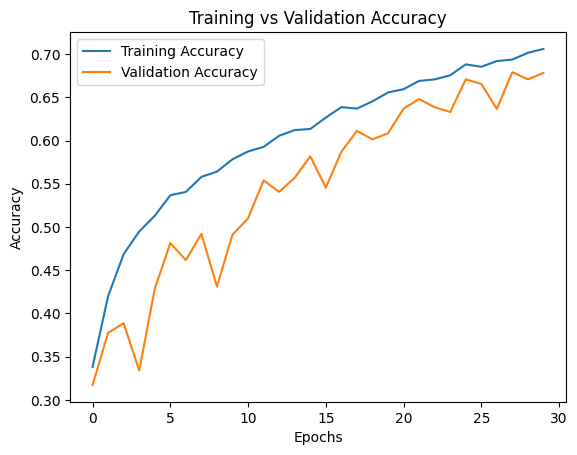

In [47]:
import matplotlib.pyplot as plt

# Make sure history is the History object returned by model.fit()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


In [48]:
model.save("skincancercnn.h5")

# Step 13 : Model Evaluation

In [49]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

450/450 ━━━━━━━━━━━━━━━━━━━━ 39s 85ms/step - accuracy: 0.7263 - loss: 0.7315
Train: accuracy = 0.725208  ;  loss = 0.727096


In [50]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.6867 - loss: 0.8742
Testing: accuracy = 0.678444  ;  loss = 0.883375


141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step


<Axes: >

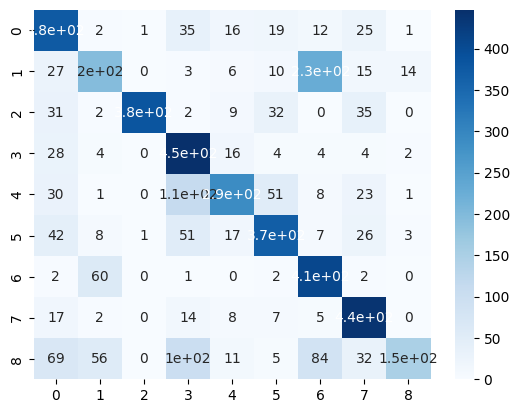

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.6784
Precision: 0.7149
Recall: 0.6806
F1-score: 0.6665
Kappa score: 0.6385


# Step 14 : Saving the model

In [53]:
 model.save("skinDiseaseDetectionUsningCNN.h5")

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Make sure you have access to label_map and input_shape from earlier code
# Example:
# label_map = {0: 'akiec', 1: 'bcc', ..., 8: 'vasc'}
label_map = {i: label for i, label in enumerate(os.listdir(train_dir))}

def predict_skin_cancer_image(image_path, model, x_train_mean, x_train_std):
    # 1. Load image using OpenCV
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found at: {image_path}")

    # 2. Resize image to match training dimensions
    img_resized = cv2.resize(img, (100, 75))  # (width, height)

    # 3. Convert BGR (OpenCV default) to RGB
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # 4. Normalize using training mean and std
    img_norm = (img_rgb - x_train_mean) / x_train_std

    # 5. Add batch dimension
    img_input = np.expand_dims(img_norm, axis=0)

    # 6. Predict
    predictions = model.predict(img_input)
    predicted_index = np.argmax(predictions)
    confidence = round(predictions[0][predicted_index] * 100, 2)

    # 7. Map label
    predicted_class = label_map[predicted_index]

    # 8. Show the image with prediction
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f'Prediction: {predicted_class} ({confidence}%)')
    plt.show()

    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


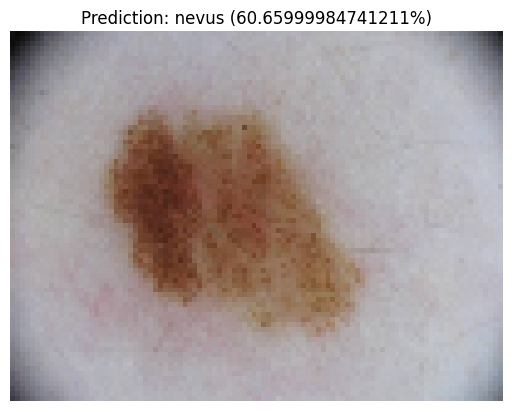

Image Path: /kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/nevus/ISIC_0000009.jpg
Predicted Class: nevus, Confidence: 60.65999984741211%


In [62]:
# Use a sample image from the ISIC dataset for prediction
image_path = "/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/nevus/ISIC_0000009.jpg"

# Run prediction
predicted_class, confidence = predict_skin_cancer_image(image_path, model, x_train_mean, x_train_std)

print(f"Image Path: {image_path}")
print(f"Predicted Class: {predicted_class}, Confidence: {confidence}%")
